In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

sys.path.append("../../src")
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification
from block_analysis import *
from derivation import hessian

## Params

In [2]:
# Model
mode = "linear"
bias = False
nlayer = 2
inp_dim = 10
out_dim = 10
hid_dim = 10

# Data parameters
nsamp = 1000
inp_mean = 0
inp_var = 1

# Others
device = 0
lr = 1

In [3]:
from derivation import infer_layer_idx

def kronecker_product(t1, t2):
    """
    """
    t1_height, t1_width = t1.size()
    t2_height, t2_width = t2.size()
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

def H22(model, x):
    """
    """
    out_dim = model.out.fc.weight.shape[0]
    with torch.no_grad():
        wx = model.l1.fc(x)
        wxxw = wx.t().mm(wx)
        Id = torch.eye(out_dim).cuda()
        return kronecker_product(Id, wxxw)
    
def H11(model, x):
    """
    """
    with torch.no_grad():
        xx = x.t().mm(x)
        w2 = model.out.fc.weight
        ww2 = w2.t().mm(w2)
        return kronecker_product(ww2, xx)
        
def H12(model, x, y, loss="linear"):
    """
    """    
    hlin = Hij_linear(model, x, y)
    if loss == "linear":
        return hlin
    else:
        return hlin + hij_squared(model, x, y)

def Hij_linear(model, x, y):
    """
    """
    with torch.no_grad():
        xy = get_xy(x, y, loss_fn).abs()
        ks = [kronecker_product(torch.eye(10).cuda(), xy[:,i:i+1]) for i in range(xy.shape[1])]
        return torch.cat(ks, 1)
        
def Hij_squared(model, x):
    """
    """
    with torch.no_grad():
        Axxt = model.l1(x.t().mm(x))
        B = model.out.fc.weight.t()
        asympath = kronecker_product(B, Axxt)

        out = x.t().mm(model(x))
        sympath = torch.cat([kronecker_product(torch.eye(10,10).cuda(), out[:,i][:,None]) for i in range(10)], 1)
        return asympath + sympath

def get_block(H, model, i, j):
    """
    """
    idx = infer_layer_idx(model.parameters())
    return H[idx[i]:idx[i+1], idx[j]:idx[j+1]]

def get_xy(x, y, loss_fn):
    """
    """
    Y = loss_fn.lookup[y.squeeze()]
    return -x.t().mm(Y)

In [4]:
def get_model_ds_loss(loss="squared", inp_mean=0):    
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = {"linear":LinearClassification,
               "squared":SquaredClassification}[loss](out_dim, reduce="sum")
    return model, ds, loss_fn

In [5]:
model, ds, loss_fn = get_model_ds_loss("squared")
loss_fn = SquaredClassification(out_dim, reduce="sum")

x,y = ds[0]
loss_fn(model(x),y).backward()
out = loss_fn(model(x),y)
H = hessian(out, model.parameters())

In [6]:
h1  = H11(model, x)
h2  = H22(model, x)
h12 = H12(model, x, y)

### Done

Formulas for diagonal and linear term of the off-diagonal

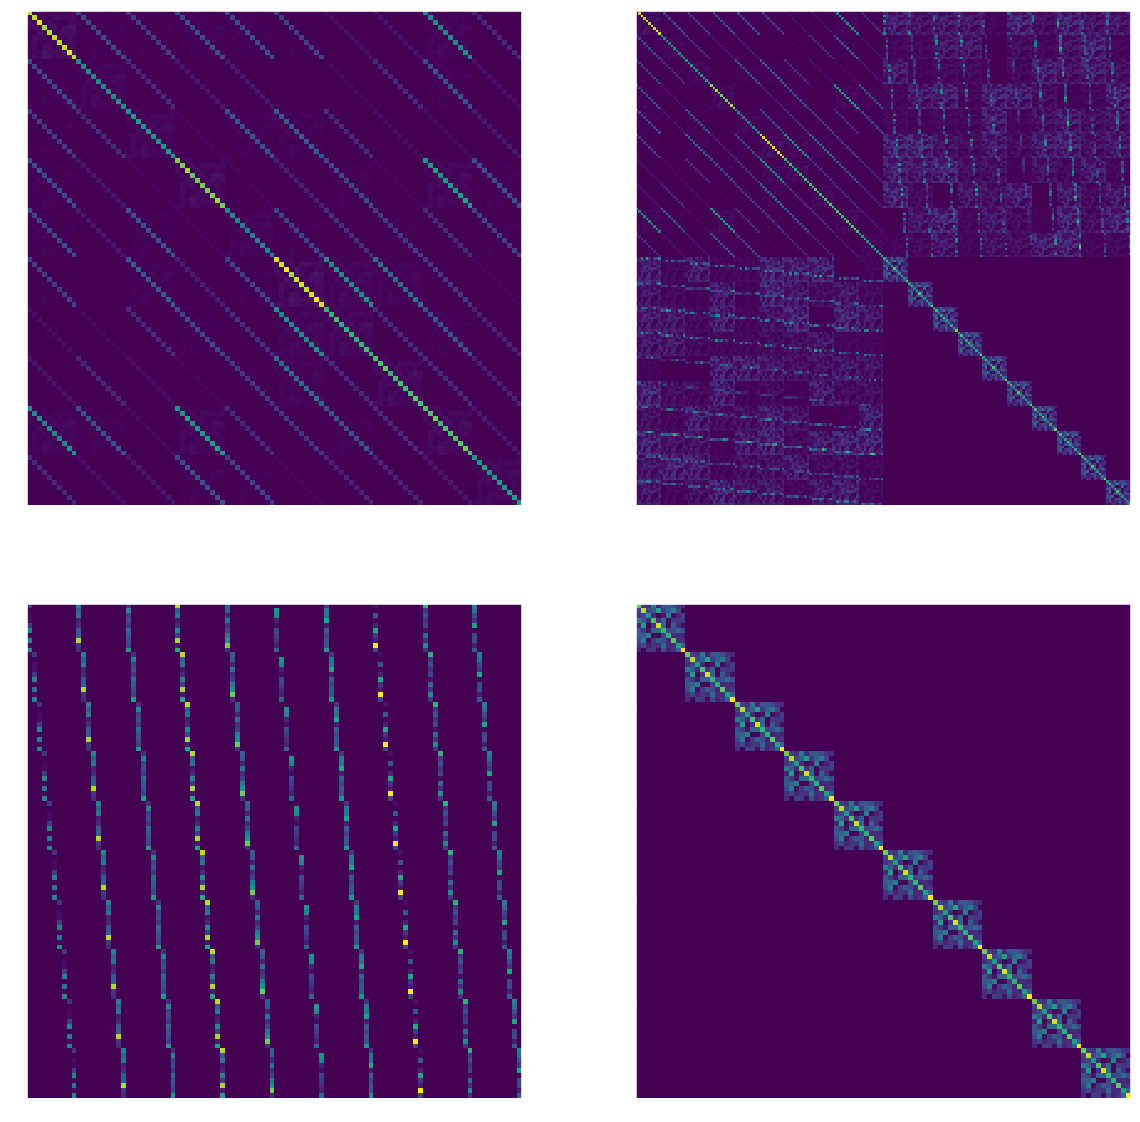

In [7]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,1].imshow(H.abs())
ax[0,0].imshow(h1.abs())
ax[1,0].imshow(h12.abs())
ax[1,1].imshow(h2.abs())

### To do:

Quadratic term of the off-diagonal

In [8]:
from losses import *

class SquaredThing(nn.Module):
    def __init__(self, target_dim, 
                 reduce="mean", device=0):
        """
        """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.lookup = torch.eye(target_dim).cuda(device)
        self.reduce = {"mean":lambda x:x.mean(),
                       "sum": lambda x:x.sum()}[reduce]
        
    def forward(self, out, label):
        """
        """
        #label = self.lookup[label.squeeze()]
        return self.reduce((out)**2) / 2

In [9]:
def func(inp_dim = 1, out_dim = 1, hid_dim = 10):
    def get_model_ds_loss(loss="squared", inp_mean=0):    
        model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
        ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                       out_dim, nsamp, device)
        loss_fn = {"linear":LinearClassification,
                   "squared":SquaredClassification}[loss](out_dim, reduce="sum")
        return model, ds, loss_fn
    
    model, ds, loss_fn = get_model_ds_loss("squared")
    loss_fn = SquaredThing(out_dim, reduce="sum")

    x,y = ds[0]
    loss_fn(model(x),y).backward()
    out = loss_fn(model(x),y)
    H = hessian(out, model.parameters())
    
    h1  = H11(model, x)
    h2  = H22(model, x)
    h12 = get_block(H, model, 0,1)
    
    fig, ax = plt.subplots(2,2, figsize=(20, 20))
    ax[0,1].imshow(H.abs())
    ax[0,0].imshow(h1.abs())
    ax[1,0].imshow(h12.abs())
    ax[1,1].imshow(h2.abs())

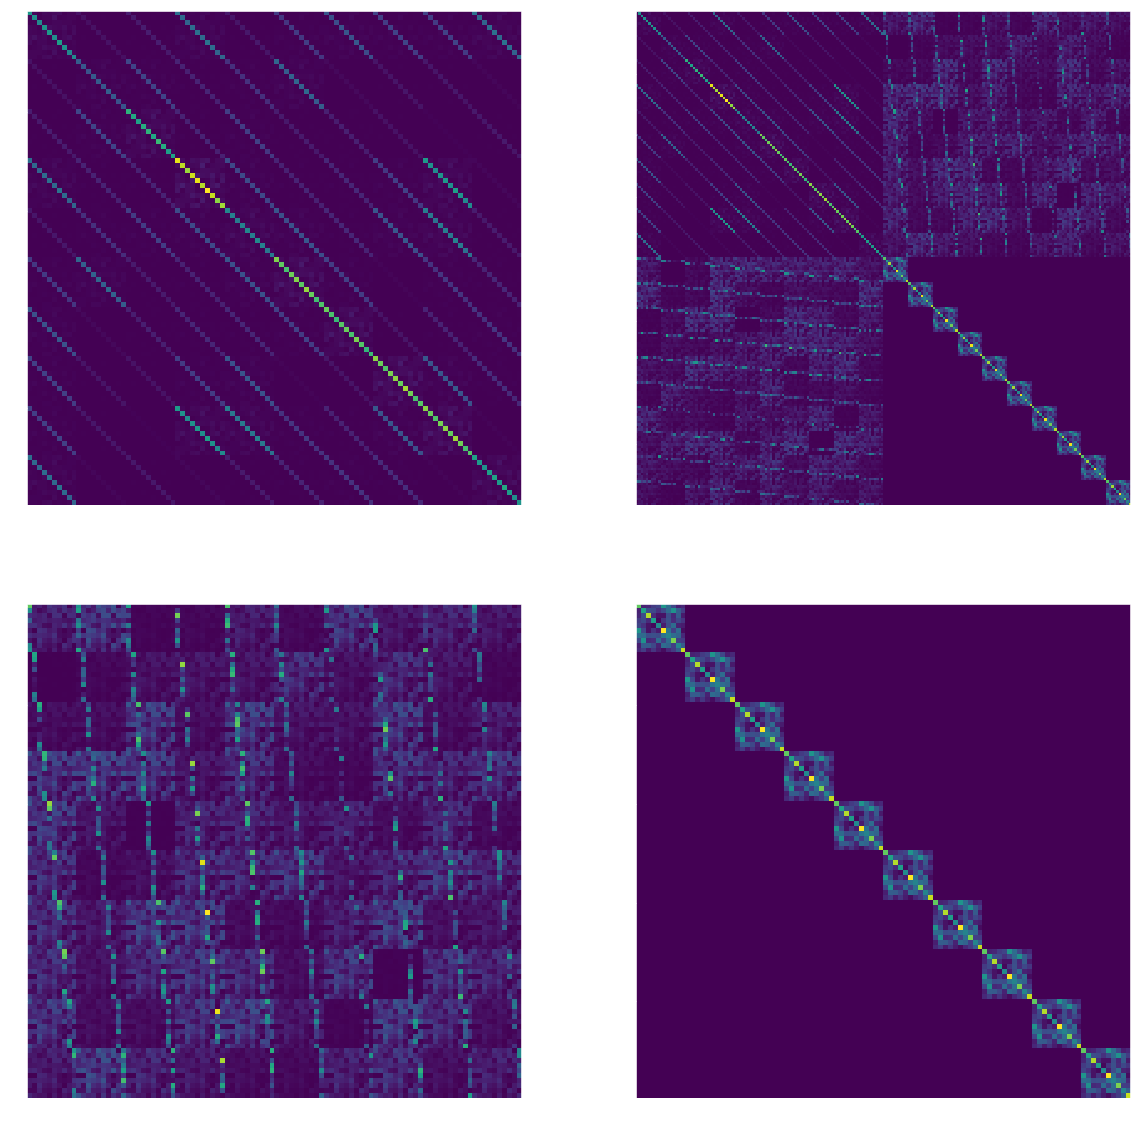

In [10]:
inp_dim = 10
out_dim = 10
hid_dim = 10
nsamp = 1000

model, ds, loss_fn = get_model_ds_loss("squared")
loss_fn = SquaredThing(out_dim, reduce="sum")

x,y = ds[0]
loss_fn(model(x),y).backward()
out = loss_fn(model(x),y)
H = hessian(out, model.parameters())

h1  = H11(model, x)
h2  = H22(model, x)
h12 = get_block(H, model, 0,1)

fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,1].imshow(H.abs())
ax[0,0].imshow(h1.abs())
ax[1,0].imshow(h12.abs())
ax[1,1].imshow(h2.abs())

In [97]:
with torch.no_grad():
    Axxt = model.l1(x.t().mm(x))
    B = model.out.fc.weight.t()
    asympath = kronecker_product(B, Axxt)

    out = x.t().mm(model(x))
    sympath = torch.cat([kronecker_product(torch.eye(10,10).cuda(), out[:,i][:,None]) for i in range(10)], 1)
h12 = asympath + sympath

torch.Size([100, 100])

In [200]:
def _1by1():
    w1 = model.l1.fc.weight
    w2 = model.out.fc.weight
    w2w1 = w2.squeeze().view(-1,1).mm(w1.squeeze().view(1,-1))
    #plt.imshow(w2w1.detach().abs())
    
    diag = torch.zeros(w1.numel(),w1.numel()).cuda()
    idx = torch.arange(w1.numel())
    diag[idx,idx] = (w1.squeeze()*w2.squeeze())
    h_12 = (4*diag + 2*w2w1) * (x**2).sum() / 2
    
    plt.imshow(h_12.detach().abs())
    
    h12 - (w2w1 * (x**2).sum() )

In [72]:
AB = x.mm(model.l1.fc.weight.t())
print(AB.shape)
ABC = AB.mm(model.out.fc.weight.t())
print(ABC.shape)
ABCCt = ABC.mm(model.out.fc.weight)
print(ABCCt.shape)

A = x
B = model.l1.fc.weight
C = model.out.fc.weight

with torch.no_grad():
    aa = x.t().mm(x)
    aaBt=aa.mm(B.t())
    aaBtC = aaBt.view(-1, 1).mm(C.view(1,-1))
#B.shape, C.shape